# Get data frames for analysis

The following notebook creates stratify sampling points inside PFT plant clases for the analyses. We use these points for extracting phenoloy variables and DEM.

Author: Javier Lopatin \
Date: 2025-11-10 \
Version: 1.0 

In [2]:
import os
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio.merge import merge
from rasterstats import zonal_stats
import numpy as np
from tqdm import tqdm       
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import rioxarray as rio

In [ ]:
# set working directory
os.chdir("/mnt/rapidita_4T/temp/Suisun/")
os.getcwd()

In [3]:
def stratified_points_in_polygon(shp, number=100, dist=10, maxiter=1000):
    '''
    Generate stratified points inside polygons
    '''    
    from shapely.geometry import Point
    import geopandas as gpd
    import random
    import multiprocessing
    from joblib import Parallel, delayed
    from tqdm import tqdm

    # read shapefile and get labels
    shp = gpd.read_file(shp)

    def my_function(j,shp):
    # ancillary funciton to be passed to the parallel processing
        polygon = shp.geometry[j]
        points = []
        min_x, min_y, max_x, max_y = polygon.bounds
        i = 0
        while len(points) < number:
            point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
            if polygon.contains(point):
                if i == 0:
                    points.append(point)
                if i != 0:
                    try:
                        points.append(point)
                        dist = [point.distance(x) for x in points][:-1]
                        # delete last point if distance to other points > dist
                        if np.any(np.array(dist) < dist):
                            points.pop() 
                    except i > maxiter:
                        sys.exit(1)                   
            i += 1       
        df = gpd.GeoDataFrame(crs=shp.crs , geometry=points)
        df['class'] = shp['NVCSName'][j]
        return df
        
    # parallel processing through the list
    num_cores = multiprocessing.cpu_count()
    outlist = Parallel(n_jobs=num_cores)(delayed(my_function)(j,shp) for j in tqdm(range(len(shp))))
    
    return pd.concat(outlist) # concatenate all data
    
def ExtractPointValues(raster, shp, bandNames, labels, num_cores=4, ID='FID'):
    from rasterstats import point_query
    import shapefile
    import multiprocessing
    from joblib import Parallel, delayed
    """ Extract raster values by a shapefile point mask.
    """

    # Shapefile management
    shape = shapefile.Reader(shp)
    records = pd.DataFrame(shape.records())
    n = pd.DataFrame(shape.fields)[0].values.tolist().index(ID)
    _id = records[n-1]

    # empty matrix to store results
    matrix = np.empty((len(records), len(bandNames)+1), dtype=object)
    matrix[:,0] = _id

    def _funtion(i,shp,raster):
        stats = point_query(shp, raster, band=i+1)
        return pd.DataFrame(stats)
    # parallel processing
    stats = Parallel(n_jobs=num_cores)(delayed(_funtion)(i,shp,raster) 
                                       for i in tqdm(range(len(bandNames))))
   
    x = pd.concat(stats, axis=1) # concatenate all dataframes into one
    x.columns = bandNames # add colum names
    x.index = records[0]  # and shapefile ID to index
    # save data to .CSV file
    name = os.path.basename(raster)
    x.to_csv(name[:-4] + ".csv", index=False, header=True, na_rep='NA')

    return x  

In [4]:
# load shapefile of PFT classes
shp = 'SHP/Suisun_PFT_diss.shp'
suisun = gpd.read_file(shp)
labels = suisun['PFT']; labels

0                       Agriculture
1                            Barren
2                               Bay
3                         Grassland
4                             Other
5     Pickleweed-Cordgrass-Saltbush
6                      Tule-Cattail
7                Urban or developed
8                             Water
9                       Wet Meadows
10                           Willow
Name: PFT, dtype: object

<AxesSubplot:>

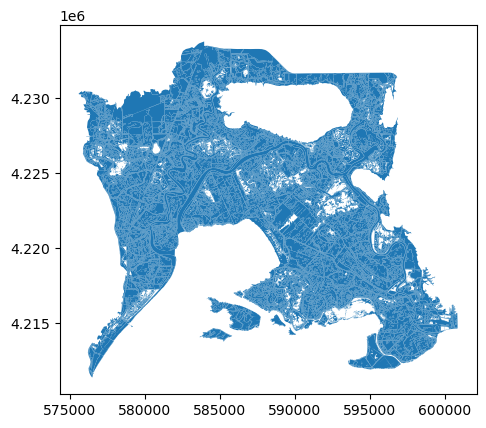

In [26]:
# exclude Bay class
suisun = suisun[suisun['PFT'] != 'Bay']
suisun.plot()

In [27]:
# generate 50 stratified points within the first county polygon in geodata
samples = stratified_points_in_polygon(shp, number=50)
samples

100%|██████████| 11/11 [00:00<00:00, 8049.08it/s]


,geometry,class
0,POINT (579524.091 4228143.840),Row and Close Grain Crop
1,POINT (595518.708 4231562.910),Row and Close Grain Crop
2,POINT (579388.984 4229087.075),Row and Close Grain Crop
3,POINT (578789.465 4229064.841),Row and Close Grain Crop
4,POINT (595121.784 4231439.059),Row and Close Grain Crop
...,...,...
45,POINT (576014.483 4226694.350),Salix laevigata / Salix lasiolepis
46,POINT (576446.092 4227478.402),Salix laevigata / Salix lasiolepis
47,POINT (576473.484 4227473.880),Salix laevigata / Salix lasiolepis
48,POINT (577850.732 4223026.573),Salix laevigata / Salix lasiolepis


<AxesSubplot:>

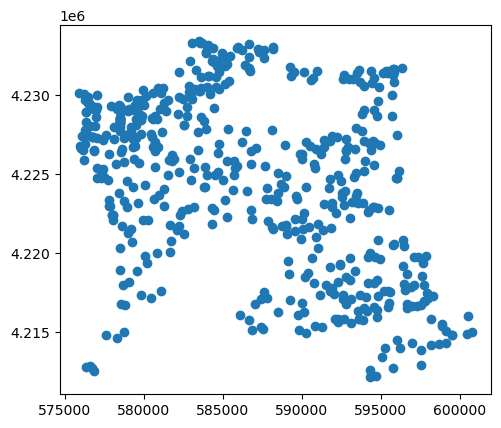

In [28]:
samples.plot()

In [29]:
samples.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
samples.to_file('SHP/samplepoints.shp')

In [34]:
# extract phenoshape

# samples using the phenoshape fits
xnew = np.linspace(5, 360, 46, dtype='int16')
bandNames = []
for i in range(46):
    a = "DOY_" + str(xnew[i])
    bandNames.append(a)
    
df_phen = ExtractPointValues(raster='Rasters/phenoshapeAll.tif', shp='SHP/samplepoints.shp', 
                             bandNames=bandNames, labels=labels, ID='class')
df_phen.head()

,DOY_5,DOY_12,DOY_20,DOY_28,DOY_36,DOY_44,DOY_52,DOY_60,DOY_68,DOY_76,...,DOY_289,DOY_296,DOY_304,DOY_312,DOY_320,DOY_328,DOY_336,DOY_344,DOY_352,DOY_360
0,,,,,,,,,,,,,,,,,,,,,
Row and Close Grain Crop,0.856370,0.782192,0.929497,1.088735,1.073339,1.360975,1.418466,1.425933,1.321941,1.436616,...,0.369102,0.371393,0.387570,0.396667,0.405455,0.406345,0.420706,0.410215,0.383810,0.368161
Row and Close Grain Crop,0.550396,0.613385,0.672446,0.744630,0.828811,0.903814,1.007791,1.046974,1.059186,1.082088,...,0.332066,0.332704,0.345297,0.350675,0.360865,0.372852,0.382676,0.365860,0.340064,0.319191
Row and Close Grain Crop,1.179485,1.081855,1.041109,1.063899,1.157304,1.294818,1.414779,1.404506,1.301640,1.348483,...,1.327660,1.325367,1.333818,1.395254,1.441379,1.364559,1.406229,1.317248,1.175115,1.104388
Row and Close Grain Crop,0.587530,1.083535,1.437775,1.748108,1.913084,2.006569,1.979852,1.817212,1.548303,1.550731,...,0.699663,0.914902,0.930984,0.964454,0.852297,0.860145,0.736545,0.670529,0.546665,0.518562
Row and Close Grain Crop,0.591291,0.542706,0.612517,0.664451,0.668875,0.806000,0.858691,0.977022,1.125425,1.335294,...,0.350785,0.354941,0.366820,0.352197,0.350792,0.337906,0.321997,0.300088,0.294830,0.282801


In [4]:
# extract point values from rasters
# samples using the LSP and %RMSE metrics
LSPbands = ['SOS', 'POS', 'EOS', 'vSOS', 'vPOS', 'vEOS', 'LOS', 'MSP', 'MAU',
            'vMSP', 'vMAU', 'AOS', 'IOS', 'ROG', 'ROS', 'SW']

df_lsp = ExtractPointValues(raster='Rasters/lspAll.tif', shp='SHP/samplepoints.shp', 
                             bandNames=LSPbands, labels=labels, ID='class')
df_lsp.head()

  0%|          | 0/16 [00:00<?, ?it/s]/home/javier/miniconda3/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/javier/miniconda3/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/javier/miniconda3/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/javier/miniconda3/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


,SOS,POS,EOS,vSOS,vPOS,vEOS,LOS,MSP,MAU,vMSP,vMAU,AOS,IOS,ROG,ROS,SW
0,,,,,,,,,,,,,,,,
Row and Close Grain Crop,32.363398,66.090195,176.038525,1.074801,1.437036,0.529525,143.675126,45.726797,117.769463,1.386347,1.075344,1.113137,144.525416,0.010934,-0.008296,-0.330317
Row and Close Grain Crop,46.079546,98.595579,188.542435,0.994613,1.215563,0.329611,142.462889,70.595579,141.595579,1.082794,0.590374,0.917850,108.876175,0.004201,-0.009853,-0.388509
Row and Close Grain Crop,68.000000,110.000000,237.998415,1.348483,1.764545,1.424027,169.998415,89.000000,174.000000,1.446319,0.666456,1.146245,191.844424,0.009906,-0.002661,-0.377839
Row and Close Grain Crop,19.000000,40.000000,191.025821,1.437775,2.006569,0.506989,172.025821,26.000000,116.950167,1.748108,1.411212,1.644000,210.188489,0.027085,-0.009931,-0.331753
Row and Close Grain Crop,47.000000,96.000000,196.583259,0.858691,1.814198,0.330979,149.583259,68.000000,143.748591,1.335294,0.464521,1.531398,132.127192,0.019500,-0.014851,0.212785


In [5]:
RMSEbands = ['nRMSE_all', 'nRMSE_beginning','nRMSE_middle','nRMSE_end']

df_rmse = ExtractPointValues(raster='Rasters/rmseAll.tif', shp='SHP/samplepoints.shp', 
                             bandNames=RMSEbands, labels=labels, ID='class')
df_rmse.head()

100%|██████████| 4/4 [00:00<00:00, 558.77it/s]


,nRMSE_all,nRMSE_beginning,nRMSE_middle,nRMSE_end
0,,,,
Row and Close Grain Crop,0.024163,0.022970,0.023234,0.022569
Row and Close Grain Crop,0.004097,0.004037,0.003840,0.003385
Row and Close Grain Crop,0.025170,0.024188,0.022459,0.018019
Row and Close Grain Crop,0.086296,0.086296,0.062158,0.013881
Row and Close Grain Crop,0.008394,0.007959,0.008105,0.007964


In [6]:
PCAbands = ['PCA1', 'PCA2','PCA3']

df_pca = ExtractPointValues(raster='Rasters/KernelPCA_clip.tif', shp='SHP/samplepoints.shp', 
                             bandNames=PCAbands, labels=labels, ID='class')
df_pca.head()

100%|██████████| 3/3 [00:00<00:00, 4208.33it/s]


,PCA1,PCA2,PCA3
0,,,
Row and Close Grain Crop,-0.068644,0.619350,0.090899
Row and Close Grain Crop,0.090807,0.616640,-0.094674
Row and Close Grain Crop,-0.108647,-0.108004,0.424826
Row and Close Grain Crop,-0.050064,0.416657,0.388750
Row and Close Grain Crop,0.082526,0.595207,0.047313


In [14]:
df_H = ExtractPointValues(raster='Rasters/dem.tif', shp='SHP/samplepoints.shp', 
                             bandNames=['H'], labels=labels, ID='class')
# nan values are replaced by 0
df_H = df_H.fillna(0)
df_H.head()
df_H.to_csv("dem.csv", index=False, header=True, na_rep='NA')

100%|██████████| 1/1 [00:00<00:00, 3258.98it/s]
